# Inverted encoding models
In the past year, I've seen several papers and posters (VSS, ICON) about 'inverted encoding models', mainly from the labs of John Serences and Tommy Sprague. This notebook consists of two parts. In the first part, I'll describe the process of estimating encoding models of neuroimaging data (e.g. fMRI) and subsequently inverting them. It is based on [code](https://github.com/tommysprague/IEM-tutorial) from Tommy Sprague's github. The second part will argue that inverted encoding models as they're traditionally used likely *very* statistically inefficient with realistic neuroimaging data.

First some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

## Part 1: encoding models (vs. decoding models) and how to invert them
Let's take a look at inverted encoding models (or: IEMs) and how they compare to "traditional" decoding models.

### 1.1. The data
Let's simulate some data. Suppose that our brain data (let's say fMRI voxels) consists of 200 trials (in which a particular stimulus is presented) and 100 voxels. (Usually, you'd use more voxels, probably, but this makes the estimation of encoding models more difficult, because OLS fails when the number of features/variables is larger than the number of samples; in that case, you'd need to use regularized models, like ridge regression.) So, our brain-data is of shape $200 \times 100$. Now, suppose that in each trial the participant saw a single stimulus with two 'levels', thus making this a binary variable (e.g. two different stimulus orientations, two colors, whatever). We'll use the codes 0 and 1 to indicate the two levels of this stimulus-feature. The shape of the array representing this stimulus information is of shape $100 \times 1$.

We'll assume that the first 100 trials are of 'level' 0 and the last 100 trials are of 'level' 1. We'll simulate the brain-data with activity drawn from a normal distribution ($\mu = 0,\ \sigma = 1$). Also, let's simulate some 'effect'. Suppose that the trials with stimuli of level 1 show an increase of activity in only the 'even' voxels (i.e., voxel 0, 2, 4, ... 198). We'll also plot the activity (y-axis) of all voxels (different lines) across all trials (x-axis) and the corresponding stimulus levels (thick blue line).

In [2]:
n_trials = 200
n_voxels = 100

stimulus = np.repeat([0, 1], repeats=n_trials / 2)
brain = np.random.normal(0, 1, size=(n_trials, n_voxels))

# Add 'effect' (i.e., an increase of 0.2)
brain[100:200, 0:n_voxels:2] += 0.2

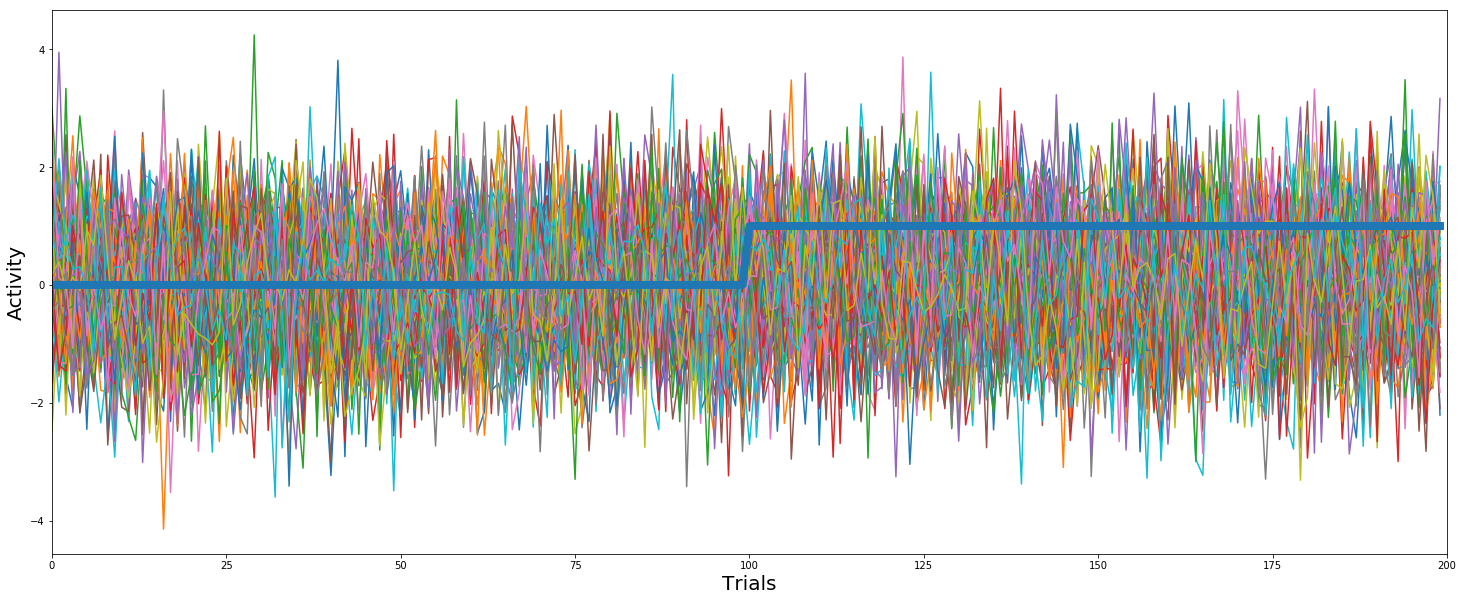

In [3]:
# Let's plot it
plt.figure(figsize=(25, 10))
plt.plot(brain)
plt.plot(stimulus, lw=8)
plt.xlim(0, n_trials)
plt.xlabel('Trials', fontsize=20)
plt.ylabel('Activity', fontsize=20)
plt.show()

### 1.2. A typical 'decoding' analysis 
Personally, I've worked at lot with "multivoxel pattern analyses" (MVPA) in which I apply machine learning models to make predictions about stimulus/task-features based on brain-data (usually fMRI). This is a type of 'decoding model', in which we treat the brain-data as (predictive) variables and the stimulus/task-feature(s) as the to-be-predicted target. Now, just for comparison to the 'inverted encoding models' (which *can* be used as a type of 'decoder') later, let's implement a simple decoding pipeline that aims to predict our stimulus variable (with levels 0 and 1) from the brain-data. We'll use scikit-learn for that of course.

First, let's define our variables. Given that this is a decoding model, we'll refer to the brain-data as `X_dec` (I usually use the symbol/name $X$ for the data that 'aims to explain') and the stimulus-variable as `y_dec` (I usually use the symbol/name $y$ for the data that 'is to-be explained').

In [4]:
X_dec = brain
y_dec = stimulus

Let's define a simple pipeline that does feature scaling and prediction using a linear SVM (seemingly the favorite classifier in cognitive neuroscience):

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

And let's evaluate the cross-validated prediction accuracy:

In [6]:
scores_dec = cross_val_score(pipeline, X=X_dec, y=y_dec, cv=5)
print("Scores for the decoding model: %.3f (%.3f)" % (scores_dec.mean(), scores_dec.std()))

Scores for the decoding model: 0.595 (0.048)


Alright, this is quite good. Now, let's check out how 'inverted encoding models' work.

### 1.3. Inversion of encoding models
For these 'inverted encoding models', we of course first need to estimate an encoding model before we can invert them! In contrast to the (machine-learning based) 'decoding model' we just discussed, which aims to predict the stimulus-feature from the brain-data (brain &rarr; stimulus), encoding models aim to investigate the influence of the stimulus on the brain (stimulus &rarr; brain; e.g. the traditional GLM-based 'statistical parametric mapping' models in fMRI).

As such, let's give the data sensible names for the encoding step:

In [7]:
X_enc = stimulus[:, np.newaxis]  # add axis of linear algebra operations later
y_enc = brain

Alright, encoding models estimate the influence of the stimulus on the brain-data. The most often-used (I think) method is to simply use the GLM to estimate the (encoding) weights (usually called 'beta-weights'). These weights are often estimated in a separate model for each voxel. Fortunately, we can estimate all these models at the same time in the GLM using linear algebra. As such, we can estimate the beta-weights, $\beta$, for all voxels (resulting in an array of shape $1 \times 100$) using the predictors ($X$, of shape $200 \times 1$) to model the brain-data ($y$, of shape $200 \times 100$):

\begin{align}
\mathbf{\hat{\beta}} = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y}
\end{align}

Let's do that here:

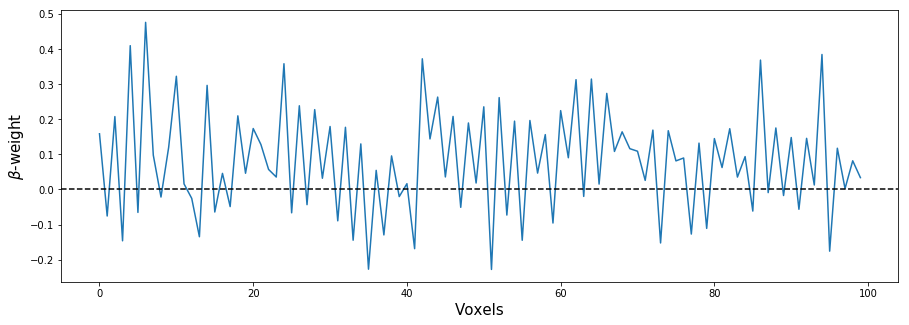

In [8]:
betas_enc = np.linalg.inv(X_enc.T @ X_enc) @ X_enc.T @ y_enc

plt.figure(figsize=(15, 5))
plt.plot(betas_enc.T)
plt.axhline(0, ls='--', c='black')
plt.xlabel('Voxels', fontsize=15)
plt.ylabel(r'$\beta$-weight', fontsize=15)
plt.show()

As you can see, the weights nicely show that only the 'even' voxels show a $\beta$-weight above 0.

Now, the 'inversion' of the encoding models is simply rearranging the formula for the beta-weights such that we estimate $X$ from the components $y$ and $\beta$, which comes down to:

\begin{align}
\mathbf{X}_{inverted} = (\hat{\beta}\hat{\beta}')^{-1}\hat{\beta}\mathbf{y}
\end{align}

Let's do that below:

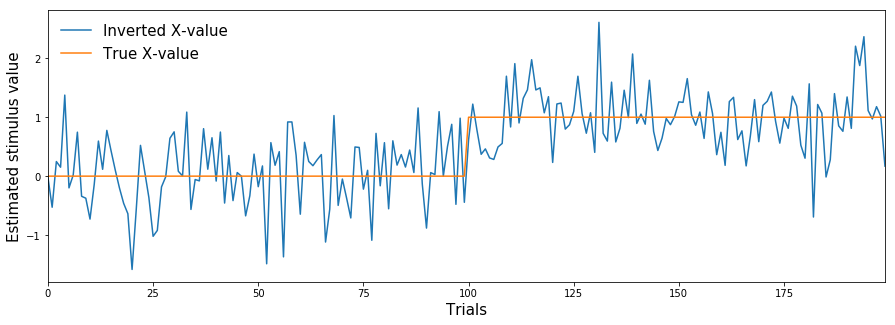

In [9]:
X_inv = np.linalg.inv(betas_enc @ betas_enc.T) @ betas_enc @ y_enc.T
plt.figure(figsize=(15, 5))
plt.plot(X_inv.T)
plt.plot(X_enc)
plt.xlabel('Trials', fontsize=15)
plt.ylabel('Estimated stimulus value', fontsize=15)
plt.xlim(0, n_trials - 1)
plt.legend(['Inverted X-value', 'True X-value'], fontsize=15, frameon=False)
plt.show()

In fact, because we have a binary stimulus-feature (0, 1), we can easily 'convert' this reconstructed $X$-values into a 'decoding model' by predicting level 1 for when the inverted $X$-value is above 0.5 and 0 elsewhere:

\begin{align}
prediction = \begin{cases}
    1,& \text{if } X_{inv} > 0.5\\
    0,              & \text{otherwise}
\end{cases}
\end{align}

Let convert the inverted X-values into predictions and let's evaluate accuracy:

In [10]:
dec_score = np.mean((X_inv > 0.5).astype(int) == X_enc.T)
print(dec_score)

0.8


Much higher than the original decoding analysis! Of course, this is probably because we did not cross-validate the 'inverted encoding model' analysis (but we did this in the decoding analysis). It is easy to cross-validate the (inverted) encoding model as follows:

\begin{align}
\mathbf{\hat{\beta}}_{train} = (\mathbf{X}_{train}'\mathbf{X}_{train})^{-1}\mathbf{X}_{train}'\mathbf{y}_{train}
\end{align}

\begin{align}
\mathbf{X}_{test} = (\mathbf{\hat{\beta}}_{train}\mathbf{\hat{\beta}}_{train}')^{-1}\mathbf{\hat{\beta}}_{train}\mathbf{y}_{test}'
\end{align}

Alright, let's check out how our inverted-encoding-model-converted-to-decoding model does when it's cross-validated:

In [11]:
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits)
cv_scores = np.zeros((n_splits, 1))

for i, (train_idx, test_idx) in enumerate(skf.split(X_dec, y_dec)):
    X_train, X_test = X_enc[train_idx], X_enc[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    betas = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    X_inv_test = np.linalg.inv(betas @ betas.T) @ betas @ y_test.T
    cv_scores[i] = ((X_inv_test.T > 0.5).astype(int) == X_test).mean()

print("Cross-valided scores: %.3f (%.3f)" % (cv_scores.mean(), cv_scores.std()))

Cross-valided scores: 0.665 (0.015)


That is quite a good score! Lower than the un-crossvalidated score (as expected), but comparable to the 'direct' decoding approach (using the SVM)!

## Part 2: why inverted encoding models are statistically inefficient
Well, IEMs are not *necessarily* statistically inefficient, but the way they are implemented most often (at least, as far as I can see) is. The biggest issue is that "traditional" IEMs assume that the parameters in the encoding model have the same variance and no covariance. Why is this a problem? Well, as you can see, the inversion step is just another ordinary least squares (OLS)regression, but this time not using the stimulus (features) as predictors, but the parameters associated with the voxels (i.e,. the $\hat{\beta}$):

\begin{align}
\mathbf{X}_{inverted} = (\hat{\beta}\hat{\beta}')^{-1}\hat{\beta}\mathbf{y}
\end{align}

In other words, the estimated parameters ($\hat{\beta}$) represent the design-matrix for OLS in the inversion step, which maps the parameters back to the stimulus. What we're neglecting in the above OLS equation, however, is that we have information about the *uncertainty* of the parameter estimates, namely their (co)variance! This is especially important when the noise in your data is not identically and uniformly distributed (as traditional IEMs implicitly assume)! 

I'll show below that IEMs "fall apart" when the level of noise ("variance") differs across neuroimaging units (e.g., voxels/sensors) or when noise is correlated ("covariance"). Also, I also propose that traditional IEMs can be greatly and easily improved by explicitly modelling the (co)variance of the parameter estimates.

### 2.1. The data
Let's create a DataGenerator class. This class can generate data that have different "noise models":

- uncorrelated and equal variance (which I call "OLS", because it complies with OLS assumptions)
- uncorrelated and different variance (which I call "WLS", because it can be efficiently estimated using "weighted least squares")
- correlated but equal variance (which I call "GLS", because it can be efficiently estimated using "generalized least squares")
- correlated and different variance (which I call "WGLS"; technically, not a very good name, but you get my drift)

Also, it is able to create "parameters" (i.e, the effects in IEMs) with prespecified distributions, but those are not used in this notebook (but they are useful to investigate the effect of parameter priors, i.e., in bayesian encoding models!).

In [12]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.linalg import toeplitz
from sklearn.discriminant_analysis import _cov, LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy import stats


class DataGenerator:

    def __init__(self, categorical=True, N=100, P=4, K=50, sig_sq=1,
                 rho=0.9, max_var=10, noise_model='ols', param_model='unif'):
        """
        parameters
        ----------
        categorical : bool
            Whether it contains a categorical target or not
        N : int
            Number of samples
        P : int
            Number of classes (when categorical)
        K : int
            Number of neuroimaging features (e.g., voxels)
        sig_sq : int/float
            General noise level
        rho : float
            AR1 parameter (only relevant for GLS noise models)
        max_var : int/float
            Maximum variance of parameters (only relevant for WLS noise models)
        noise_model : str
            Either 'OLS', 'WLS', 'GLS', or 'WGLS'
        param_model : str
            Model/distribution of effects (i.e., true "betas")
        """
        self.categorical = categorical
        self.N = N
        self.P = P
        self.K = K
        self.sig_sq = sig_sq
        self.rho = rho  # ar1 param
        self.max_var = max_var
        self.noise_model = noise_model
        self.param_model = param_model

    def generate(self):
        """ Generates the data (S = stimulus, R = response/brain). """
        N, P, K = self.N, self.P, self.K
        S = self._generate_design()
        eps = self._generate_noise()
        W = self._generate_params()
        R = S.dot(W) + eps

        if self.categorical:
            S = np.argmax(S, axis=1)

        return S, R

    def _generate_design(self):
        
        N, P = self.N, self.P
        if self.categorical:
            S_tmp = np.repeat(np.arange(P), N / P)[:, np.newaxis]
            S = OneHotEncoder(sparse=False).fit_transform(S_tmp)
        else:
            S = np.random.normal(0, 1, size=(N, P))

        return S

    def _generate_noise(self):
        """ Generates the noise. """
        N, K = self.N, self.K
        noise_mu = np.zeros(K)

        if self.noise_model == 'OLS':
            noise_cov = np.identity(K)
        elif self.noise_model in ['WLS', 'GLS', 'WGLS']:

            if self.noise_model == 'GLS':
                # assuming equal variance, but with non-zero covariance
                noise_cov = self.rho ** toeplitz(np.arange(K))
            else:
                varz = np.random.uniform(0, self.max_var, size=K)
                if self.noise_model == 'WLS':
                    noise_cov = np.diag(varz)
                else:    
                    corr_cov = self.rho ** toeplitz(np.arange(K))
                    varz = varz[:, np.newaxis]
                    noise_cov = np.sqrt(varz.dot(varz.T))
                    noise_cov *= corr_cov

        noise = np.random.multivariate_normal(noise_mu, self.sig_sq*noise_cov, size=N)
        return noise
    
    def _generate_params(self):
        """ Generates the effects/parameters (betas/weights). """
        P, K = self.P, self.K

        params_mu = np.zeros(P)
        if self.param_model == 'unif':
            W = np.random.uniform(-.5, .5, size=(P, K))
        elif self.param_model == 'OLS':
            params_cov = np.identity(P) / 10
            W = np.random.multivariate_normal(params_mu, params_cov, size=K).T
        elif self.param_model == 'GLS':
            params_cov = 0.5 ** toeplitz(np.arange(P))
            W = np.random.multivariate_normal(params_mu, params_cov, size=K).T
        elif self.param_model == 'WLS':    
            varz = np.random.uniform(0, 1, size=P)
            params_cov = np.diag(varz)
            W = np.random.multivariate_normal(params_mu, params_cov, size=K).T
        elif self.param_model == 'WGLS':
            varz = np.random.uniform(0, 1, size=P)[:, np.newaxis]
            params_cov = np.sqrt(varz.dot(varz.T))
            params_cov *= 0.5 ** toeplitz(np.arange(P))
            W = np.random.multivariate_normal(params_mu, params_cov, size=K).T
            
        return W

### 2.2. The models
Here, I create a scikit-learn style "estimator" for different IEM-models. The `IEM` class is a base-class, which performs some housekeeping stuff. Importantly, the `OlsIEM` class represents the "traditional" IEM, which does not explicitly model the (co)variance of the parameters.

In [13]:
class IEM(BaseEstimator, RegressorMixin):
    """ Base class for Inverted Encoding Model. """

    def __init__(self, classify=True, score_func=None):
        """ Initializes base class. """
        self.W = None  # estimated parameters
        self.classify = classify

    def _preproc(self, S):
        """ Preprocesses stimulus features (S). """
        if self.classify and S.ndim == 1:
            S = OneHotEncoder(sparse=False).fit_transform(S[:, np.newaxis])
        elif not self.classify and S.ndim == 1:
            S = np.c_[np.ones(S.shape[0]), S]

        return S
    
    def _classify(self, S_pred):
        """ Makes predictions categorical. """
        return np.argmax(S_pred, axis=0)

    def fit(self, R, S):
        """ Fits model (should be defined in child class). """
        raise NotImplementedError

    def predict(self, R):
        """ Predicts new stimuli based on responses
        (should be defined in child class). """
        raise NotImplementedError

    def score(self, R, S):
        """ Scores prediction. """
        S_pred = self.predict(R)
        
        if self.classify:
            return np.mean(S_pred == S)

class OlsIEM(IEM):

    def fit(self, R, S):
        
        S = self._preproc(S)
        self.W = np.linalg.inv(S.T @ S) @ S.T @ R
        return self

    def predict(self, R):
        S_pred = np.linalg.pinv(self.W @ self.W.T) @ self.W @ R.T
        
        if self.classify:
            S_pred = self._classify(S_pred)

        return S_pred

Now, as I said before, it's kind of inefficient *not* to model the parameter (co)variance. Note that it's not **wrong** (i.e., it's not biased), but it's not very efficient (technically, the traditional IEM estimator often has a larger *variance* than necessary). So, below, I've created a couple of other IEMs, which explicitly model the potentially differences in variance of the parameters (the `WlsIEM`), or the variance and covariance of the parameters (the `GlsIem`). I also added a Ridge-version of the `GlsIEM`, but that's not important for now (but it may be useful, as it allows you to regularize IEMs!).

In [14]:
class WlsIEM(IEM):
    
    def fit(self, R, S):
        
        S = self._preproc(S)
        self.W = np.linalg.inv(S.T @ S) @ S.T @ R
        resids = R - S @ self.W
        var_err = np.var(resids, axis=0)
        omega = np.eye(resids.shape[1])
        np.fill_diagonal(omega, var_err)
        self.omega = np.linalg.inv(omega)
        return self

    def predict(self, R):
        W, omega = self.W, self.omega
        S_pred = np.linalg.pinv(W @ omega @ W.T) @ W @ omega @ R.T

        if self.classify:
            S_pred = self._classify(S_pred)

        return S_pred

    
class GlsIEM(IEM):
    
    def __init__(self, shrink_cov='auto', classify=True):
        self.shrink_cov = shrink_cov
        super().__init__(classify=classify)
    
    def fit(self, R, S):
        
        S = self._preproc(S)
        self.W = np.linalg.inv(S.T @ S) @ S.T @ R
        resids = R - S @ self.W
        cov_err = _cov(resids, shrinkage=self.shrink_cov)
        self.omega = np.linalg.inv(cov_err)

        return self

    def predict(self, R):
        W, omega = self.W, self.omega
        S_pred = np.linalg.pinv(W @ omega @ W.T) @ W @ omega @ R.T

        if self.classify:
            S_pred = self._classify(S_pred)

        return S_pred


class RidgeGlsIEM(GlsIEM):

    def __init__(self, alpha=1, classify=True, shrink_cov='auto'):
        self.alpha = alpha
        super().__init__(classify=classify, shrink_cov=shrink_cov)   

    def predict(self, R):
        
        W, omega = self.W, self.omega
        S_pred = (np.linalg.pinv(W @ omega @ W.T) + self.alpha*np.eye(W.shape[0])) @ W @ omega @ R.T

        if self.classify:
            S_pred = self._classify(S_pred)
        
        return S_pred

Technically, the only thing that these variations (relative to the traditional IEM) do is that they add an estimate of the inverse of the noise covariance matrix ($\hat{\Omega}$), which is calculated as follows:

\begin{align}
\hat{\Omega} = [(y - X\hat{\beta})'(y - X\hat{\beta})]^{-1}
\end{align}

For the `WlsIEM`, only the diagonal of $\hat{\Omega}$ contains values (the other values are zero, as they reflect the correlations) and for the `GlsIEM`, the off-diagonal values are also non-zero. Note that these approaches are very similar to the bayesian decoding approaches advocated by Jehee and colleagues and the crossnobis distance advocated by Kriegeskorte and colleagues. Note that I regularize the covariance estimate using Ledoit-Wolf shrinkage (to avoid overfitting the covariance estimation).

### 2.3. Putting IEMs to the test
Alright, let's see how IEMs (and their variations) perform on data with different noise structures. We're going to test the traditional IEM (`OlsIEM`) and some of the variations that I created which should be able to deal more efficiently with unequal variance across voxels (`WlsIEM`) and/or correlated noise/covariance (`GlsIEM`).

In other words, I'm going to try three different estimators (`OlsIEM`, `WlsIEM`, and `GlsIEM`) on data with three noise models ("OLS", "WLS", and "GLS"). I expect that the traditional IEM (`OlsIEM`) is going to do much worse on data with noise with unequal variance and/or covariance.

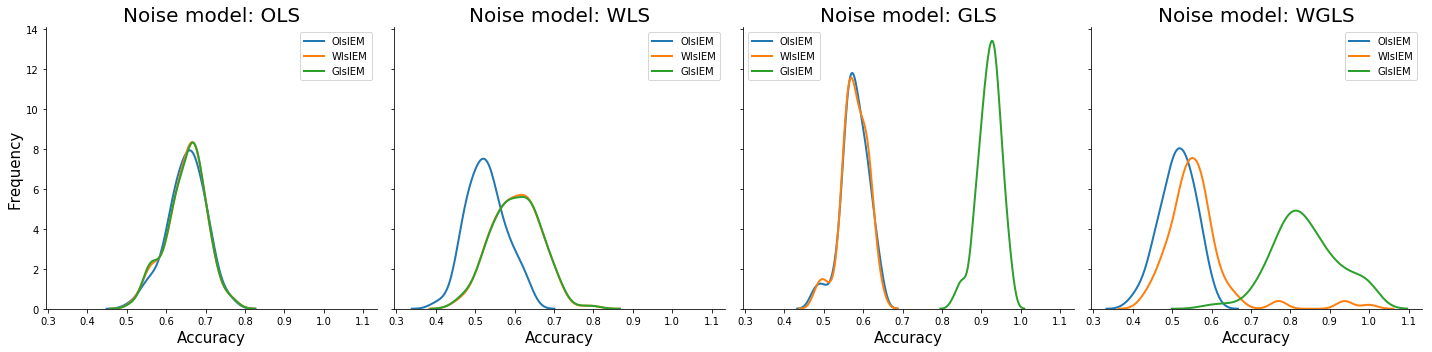

In [15]:
N = 200
P = 2
K = 100
sig_sq = 10

iters = 100
fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharex=True, sharey=True)
clfs = [OlsIEM(), WlsIEM(), GlsIEM()]#, GaussianNB()]#, LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
for i, noise_model in enumerate(['OLS', 'WLS', 'GLS', 'WGLS']):
    scores = np.zeros((iters, len(clfs)))

    for ii in range(iters):

        S, R = DataGenerator(categorical=True, N=N, P=P, K=K, sig_sq=sig_sq,
                             noise_model=noise_model).generate()

        for iii, clf in enumerate(clfs):
            scores[ii, iii] = cross_val_score(estimator=clf, X=R, y=S, cv=10).mean()

    for ii in range(scores.shape[1]):
        sns.distplot(scores[:, ii], ax=axes[i], hist=False, label=clfs[ii].__class__.__name__,
                     kde_kws={'lw': 2})

    axes[i].set_title('Noise model: %s' % noise_model, fontsize=20)
    axes[i].set_xlabel('Accuracy', fontsize=15)
    
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=15)

sns.despine()
fig.tight_layout()

### 2.4. Similarity to existing decoding (ML) models


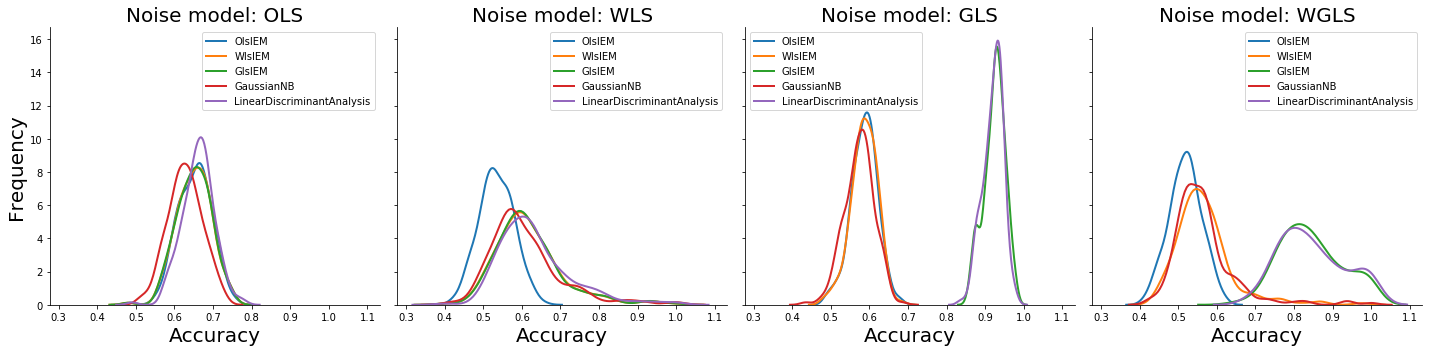

In [20]:
iters = 200
fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharex=True, sharey=True)
clfs = [OlsIEM(), WlsIEM(), GlsIEM(), GaussianNB(), LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')]

for i, noise_model in enumerate(['OLS', 'WLS', 'GLS', 'WGLS']):
    scores = np.zeros((iters, len(clfs)))

    for ii in range(iters):

        S, R = DataGenerator(categorical=True, N=N, P=P, K=K, sig_sq=sig_sq,
                             noise_model=noise_model).generate()

        for iii, clf in enumerate(clfs):
            scores[ii, iii] = cross_val_score(estimator=clf, X=R, y=S, cv=10).mean()

    for ii in range(scores.shape[1]):
        sns.distplot(scores[:, ii], ax=axes[i], hist=False, label=clfs[ii].__class__.__name__,
                     kde_kws={'lw': 2})

    axes[i].set_title('Noise model: %s' % noise_model, fontsize=20)
    axes[i].set_xlabel('Accuracy', fontsize=20)
    
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=20)

sns.despine()
fig.tight_layout()